In [1]:
%matplotlib inline


In [2]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from lightkurve import TessLightCurveFile
from astropy.coordinates import SkyCoord
import astropy.units as u
import lightkurve
import theano
import exoplanet as xo
import pymc3 as pm
import theano.tensor as tt
from astropy.stats import BoxLeastSquares


In [3]:
print(xo.__version__)
print(theano.__version__)
print(pm.__version__)

0.1.4
1.0.3
3.6


In [4]:
target = 'l 98-59'
tpf = lightkurve.search_targetpixelfile(target).download()

In [5]:
texp = tpf.hdu[1].header['FRAMETIM'] * tpf.hdu[1].header["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0
ref_time = 0.5 * (tpf.time.min() + tpf.time.max())
flux = tpf.flux

pix_mask = tpf.create_threshold_mask(threshold=3)

In [6]:
lc = tpf.extract_aperture_photometry(aperture_mask=pix_mask, )
lc = lc.normalize()
lc.flux = (lc.flux - 1.0) * 1e3
# Build the first order PLD basis
X_pld = np.reshape(flux[:, pix_mask], (len(flux), -1))
X_pld = X_pld / np.sum(flux[:, pix_mask], axis=-1)[:, None]

# Build the second order PLD basis and run PCA to reduce the number of dimensions
X2_pld = np.reshape(X_pld[:, None, :] * X_pld[:, :, None], (len(flux), -1))
U, _, _ = np.linalg.svd(X2_pld, full_matrices=False)
X2_pld = U[:, :X_pld.shape[1]]

# Construct the design matrix and fit for the PLD model
X_pld = np.concatenate((np.ones((len(flux), 1)), X_pld, X2_pld), axis=-1)
XTX = np.dot(X_pld.T, X_pld)
w_pld = np.linalg.solve(XTX, np.dot(X_pld.T, lc.flux))
pld_flux = np.dot(X_pld, w_pld)


In [7]:
period_grid = np.exp(np.linspace(np.log(0.1), np.log(15), 50000))
duration = 0.03

bls_periods = np.zeros([3])
bls_t0s = np.zeros([3])
bls_depths = np.zeros([3])
time = lc.time - ref_time

# planet 1
bls = BoxLeastSquares(time, lc.flux - pld_flux)
bls_power = bls.power(period_grid, duration, oversample=20)

bls_power0 = bls_power

# Save the highest peak as the planet candidate
index = np.argmax(bls_power.power)
bls_period = bls_power.period[index]
bls_t0 = bls_power.transit_time[index]
bls_depth = bls_power.depth[index]
transit_mask = bls.transit_mask(time, bls_period, 3*duration, bls_t0)

bls_periods[0] = bls_period
bls_t0s[0] = bls_t0
bls_depths[0] = bls_depth

# planet 2
bls = BoxLeastSquares(time[~transit_mask], lc.flux[~transit_mask] - pld_flux[~transit_mask])
bls_power = bls.power(period_grid, duration, oversample=20)

# Save the highest peak as the planet candidate
index = np.argmax(bls_power.power)
bls_period = bls_power.period[index]
bls_t0 = bls_power.transit_time[index]
bls_depth = bls_power.depth[index]
transit_mask = np.logical_or((transit_mask), (bls.transit_mask(time, bls_period, 3*duration, bls_t0)))

bls_periods[1] = bls_period
bls_t0s[1] = bls_t0
bls_depths[1] = bls_depth

# planet 3
bls = BoxLeastSquares(time[~transit_mask], lc.flux[~transit_mask] - pld_flux[~transit_mask])
bls_power = bls.power(period_grid, duration, oversample=20)

# Save the highest peak as the planet candidate
index = np.argmax(bls_power.power)
bls_period = bls_power.period[index]
bls_t0 = bls_power.transit_time[index]
bls_depth = bls_power.depth[index]
transit_mask = np.logical_or((transit_mask), (bls.transit_mask(time, bls_period, 3*duration, bls_t0)))

bls_periods[2] = bls_period
bls_t0s[2] = bls_t0
bls_depths[2] = bls_depth

In [8]:
m = ~transit_mask
XTX = np.dot(X_pld[m].T, X_pld[m])
w_pld = np.linalg.solve(XTX, np.dot(X_pld[m].T, lc.flux[m]))
pld_flux = np.dot(X_pld, w_pld)

x = np.ascontiguousarray(lc.time-ref_time, dtype=np.float64)
y = np.ascontiguousarray(lc.flux-pld_flux, dtype=np.float64)

In [9]:
def build_model(mask=None, start=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    with pm.Model() as model:

        # Parameters for the stellar properties
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        u_star = xo.distributions.QuadLimbDark("u_star",
                                              testval=np.array([0.3, 0.2]))
        
        # Stellar parameters from Kostov et al (2018)
        R_star_kostov = 0.291, 0.025
#         M_star_kostov = 0.32, 0.025
        Rho_star_kostov = 18.0
#         m_star = pm.Normal("m_star", mu=M_star_kostov[0], sd=M_star_kostov[1])
        r_star = pm.Normal("r_star", mu=R_star_kostov[0], sd=R_star_kostov[1])

        logrho_star = pm.Normal("logrho_star", mu=np.log(Rho_star_kostov), sd=0.1)
        rho_star = pm.Deterministic("rho_star", tt.exp(logrho_star))

        # Prior to require physical parameters
#         pm.Potential("m_star_prior", tt.switch(m_star > 0, 0, -np.inf))
        pm.Potential("r_star_prior", tt.switch(r_star > 0, 0, -np.inf))
#         pm.Potential("rho_star_prior", tt.switch(rho_star > 0, 0, -np.inf))

        # Orbital parameters for the planets
        logP = pm.Normal("logP", mu=np.log(bls_periods), sd=0.1, shape=3)
        t0 = pm.Normal("t0", mu=bls_t0s, sd=0.1, shape=3)
        logror = pm.Normal("logror", mu=np.log(np.sqrt(1e-3)*np.sqrt(bls_depths)),
                           sd=2, shape=3)
        ror = pm.Deterministic("r", tt.exp(logror))
        b_param = pm.Uniform("b_param", lower=[0,0.3,0], upper=[0.8,1,0.8], shape=3)
        b = pm.Deterministic("b", b_param * (1 + ror))
#         ror, b = xo.distributions.get_joint_radius_impact(
#             min_radius=0.01, max_radius=0.3,
#             testval_r=np.sqrt(1e-3)*np.sqrt(bls_depths),
#             testval_b=[0.1,0.8,0.1])
        ecc = pm.Bound(pm.Beta, lower=0.0, upper=0.8)("ecc", alpha=0.867, beta=3.03,
                                                       testval=[0.1,0.1,0.1], shape=3)
#         ecc = pm.Beta('ecc', alpha=0.867, beta=3.03, testval=[0.03,0.02,0.04], shape=3)
        omega = xo.distributions.Angle("omega", shape=3)
        
        # Log-uniform prior on ror
        pm.Potential("ror_prior_lo", tt.switch(tt.all(0.005 < ror), 0.0, -np.inf))
        pm.Potential("ror_prior_hi", tt.switch(tt.all(ror < 0.3), 0.0, -np.inf))
#         pm.Potential("ror_prior", -tt.log(ror))

        # Transit jitter & GP parameters
        logs2 = pm.Normal("logs2", mu=np.log(np.var(y[mask])), sd=10)
        logS0 = pm.Normal("logS0", mu=np.log(np.var(y[mask])), sd=10)
        logw0 = pm.Normal("logw0", mu=np.log(2*np.pi/10), sd=10)

        # Tracking planet parameters
        period = pm.Deterministic("period", tt.exp(logP))
        r_pl = pm.Deterministic("r_pl", r_star * ror)
        r_ple = pm.Deterministic("r_ple", (r_star * ror / 0.009155))

        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star, #m_star=m_star,
            period=period, t0=t0, b=b,
            ecc=ecc, omega=omega,
            rho_star=rho_star,
            )
        
        a = pm.Deterministic("a", orbit.a)
        aAU = pm.Deterministic("aAU", orbit.a * r_star / 215.9)
        pm.Potential("ecc_prior", tt.switch((ecc < 1 - (1/a)), 0, -np.inf))

        # Compute the model light curve using starry
        light_curves = xo.StarryLightCurve(u_star).get_light_curve(
            orbit=orbit, r=r_pl, t=x[mask], texp=texp)*1e3
        light_curve = pm.math.sum(light_curves, axis=-1)
        pm.Deterministic("light_curve", light_curve)
        model.light_curves = light_curves

        # GP model for the light curve
        kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
        gp = xo.gp.GP(kernel, x[mask], tt.exp(logs2) + tt.zeros(mask.sum()), J=2)
        pm.Potential("transit_obs", gp.log_likelihood(y[mask] - light_curve - mean))
        pm.Deterministic("gp_pred", gp.predict())

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = pm.find_MAP(start=start, vars=[logs2, logS0, logw0])
#         map_soln = pm.find_MAP(start=map_soln, vars=[model.rb])
        map_soln = pm.find_MAP(start=map_soln, vars=[model.logror, model.b_param])
        map_soln = pm.find_MAP(start=map_soln)

    return model, map_soln

model0, map_soln0 = build_model()

/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
  0%|          | 0/5000 [00:00<?, ?it/s]/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequ

In [10]:
mod = map_soln0["gp_pred"] + map_soln0["mean"] + map_soln0["light_curve"]
resid = y - mod
rms = np.sqrt(np.median(resid**2))
mask = np.abs(resid) < 4.5 * rms

In [11]:
model, map_soln = build_model(mask, map_soln0)

/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -22,166, ||grad|| = 361.18: 100%|██████████| 6/6 [00:00<00:00, 98.82it/s]
logp = -22,157, ||grad|| = 0.049085: 100%|██████████| 22/22 [00:00<00:00, 102.11it/s] 
logp = -22,156, ||grad|| = 151.64: 100%|██████████| 34/34 [00:00<00:00, 75.08it/s]  


In [12]:
np.savetxt('l98-59-s001lc.txt', np.array([x[mask], y[mask]]).T, delimiter=',')
print(ref_time)

1367.8107130974502


In [13]:
with model:
    trace = pm.load_trace('.l98.trace')

In [14]:
pm.summary(trace, varnames= ['b', 'r', 't0', 'period', 'r_star', 'u_star',  'logw0', 'logS0',
                             'logs2', 'mean', 'r_ple', 'rho_star'], alpha=0.32)

,mean,sd,mc_error,hpd_16,hpd_84,n_eff,Rhat
b__0,0.268587,0.187785,0.002652,0.000057,0.335057,4594.653697,1.000288
b__1,0.830858,0.113880,0.002721,0.818924,0.923918,1819.833623,1.001351
b__2,0.320188,0.187182,0.002320,0.063535,0.467576,6172.522501,1.000486
r__0,0.040737,0.001354,0.000015,0.039534,0.041980,5897.796114,1.000272
r__1,0.043590,0.006280,0.000219,0.040189,0.045859,811.911084,1.000827
r__2,0.022613,0.001254,0.000013,0.021419,0.023893,9406.626627,1.000215
t0__0,-0.535579,0.000563,0.000006,-0.536196,-0.535064,9358.609959,0.999944
t0__1,-5.073224,0.000747,0.000007,-5.073872,-5.072398,13881.577154,1.000289
t0__2,-1.639982,0.001135,0.000017,-1.640855,-1.638910,4504.828195,1.000794
period__0,3.690412,0.000223,0.000002,3.690174,3.690633,10918.235996,1.000270


In [15]:
samples = pm.trace_to_dataframe(trace)

In [16]:
q = np.percentile(samples.loc[:, ['logP__0', 'period__0', 'r__0', 'r_ple__0', 'a__0', 'aAU__0']], [16,50,84], axis=0)

In [17]:
for i in range(7):
    print(q[0, i], q[1, i], q[2, i])

1.3056762731920744 1.3057354127063634 1.305801466350057
3.6901838224437986 3.6904020645759985 3.6906458371300017
0.03947324769909409 0.04069919833799361 0.04192332374045155
1.1764534670164024 1.2919596764512722 1.4108791051799616
6.18827184262528 6.80010273959215 7.419351873559702
0.007642048941329823 0.009163538963613585 0.010816552947085679


IndexError: index 6 is out of bounds for axis 1 with size 6

In [18]:
np.percentile(samples.loc[:, ['t0__2']], [16,50,84], axis=0) + ref_time

array([[1366.16980464],
       [1366.17080157],
       [1366.17175562]])

In [19]:
def get_ar(rho,period):
    """ gets a/R* from period and mean stellar density"""
    G = 6.67E-11
    rho_SI = rho * 1000.
    tpi = 3. * np.pi
    period_s = period * 86400.
    part1 = period_s**2 * G * rho_SI
    ar = (part1 / tpi)**(1./3.)
    return ar

def get_insol(teff, ars):
    return (teff/5778)**4 * (215.1/ars)**2

In [20]:
np.percentile(get_ar(samples.loc[:, 'rho_star'], samples.loc[:, 'period__1']) *
              samples.loc[:, 'r_star'] / 215.9, [16,50,84])

array([0.0457786 , 0.05030617, 0.05488683])

In [21]:
teff = np.random.normal(3500,150,size=samples.loc[:, 'rho_star'].shape[0])
np.percentile(get_insol(teff, get_ar(samples.loc[:, 'rho_star'], samples.loc[:, 'period__1'])),
              [16,50,84])

array([3.70668131, 4.46657166, 5.35347175])

In [22]:
with model:
    orbit = xo.orbits.KeplerianOrbit(
                r_star=0.117,
                period=1.51, t0=0, b=0.,
                rho_star=71.5, ecc=0., omega=0)
    print(xo.eval_in_model(orbit.a))

2.3987690077442667


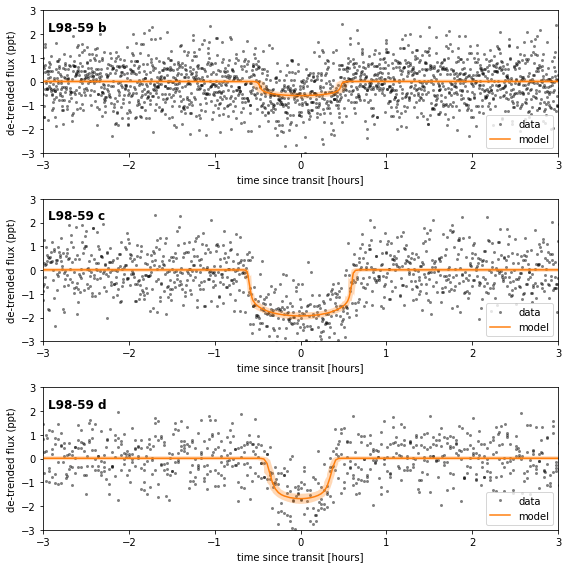

In [23]:
# Compute the GP prediction
gp_mod = np.median(trace["gp_pred"] , axis=0)

pletter = ['b', 'c', 'd']
fig,  axes = plt.subplots(3,1, figsize=[8, 8])
for i, pnum in enumerate([2,0,1]):
    ax1 = axes[i]
    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:,pnum])
    t0 = np.median(trace['t0'][:,pnum])

    # Plot the folded data

    x_fold = (x[mask] - t0 + 0.5*p) % p - 0.5*p
    ax1.plot(x_fold * 24., y[mask] - gp_mod, ".k", label="data",
             alpha=0.5, zorder=-1000, mec="none")

    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = np.add(trace['mean'], trace["light_curve"][:, inds].T ).T
    pred = np.percentile(pred, [5, 50, 95], axis=0)
    ax1.plot(x_fold[inds] * 24., pred[1], color="C1", label="model")
    art = ax1.fill_between(x_fold[inds] * 24., pred[0], pred[2], color="C1", alpha=0.3,
                           zorder=1000)
    art.set_edgecolor("none")

    # Annotate the plot with the planet's period
#     txt = "period = {0:.5f} +/- {1:.5f} days".format(
#         np.mean(trace["period"][:,pnum]), np.std(trace["period"][:,pnum]))

#     ax1.annotate(txt, (0, 0.8), xycoords="axes fraction",
#                  xytext=(5, 5), textcoords="offset points",
#                  ha="left", va="bottom", fontsize=12)
#     txt = "radius = {0:.2f} +/- {1:.2f} $R_\oplus$".format(
#         np.mean(trace["r_ple"][:,pnum]), np.std(trace["r_ple"][:,pnum]))
#     ax1.annotate(txt, (0.6, 0.8), xycoords="axes fraction",
#                  xytext=(5, 5), textcoords="offset points",
#                  ha="left", va="bottom", fontsize=12)
    ax1.annotate('L98-59 ' + pletter[i], (0., 0.8), xycoords="axes fraction",
                 xytext=(5, 5), textcoords="offset points",
                 ha="left", va="bottom", fontsize=12, weight='bold')


    ax1.legend(fontsize=10, loc=4)
    ax1.set_xlabel("time since transit [hours]")
    ax1.set_ylabel("de-trended flux (ppt)")
    ax1.set_xlim(-3, 3);
    ax1.set_ylim(-3, 3);

plt.tight_layout()
# plt.savefig('l98-transit-plot3.png', dpi=200)

In [24]:
samples.loc[:, 'rho_star'].shape[0]

20000

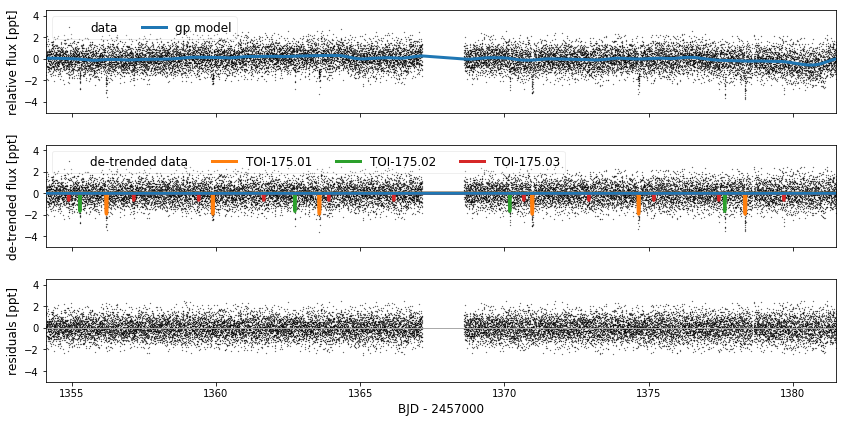

In [60]:
def plot_light_curve(model, soln, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(3, 1, figsize=(12, 6), sharex=True, sharey=True)

    ax = axes[0]
    ax.plot(x[mask] + ref_time, y[mask], ".k", label="data", ms=0.5)
    gp_mod = xo.utils.eval_in_model(model.gp_pred, soln, model=model)
    gp_mod += soln["mean"]
    ax.plot(x[mask] + ref_time, gp_mod, color="C0", label="gp model", lw=3)
    ax.legend(fontsize=12, ncol=2, loc=2, framealpha=0.3)
    ax.set_ylabel("relative flux [ppt]", fontsize=12)
    ax.set_ylim(-5, 4.5)

    ax = axes[1]
    ax.plot(x[mask] + ref_time, y[mask] - gp_mod, ".k", label="de-trended data", ms=0.5, lw=3)
    ax.plot(x[mask] + ref_time, np.zeros_like(x[mask]), lw=3, zorder=1000)
    light_curves = xo.utils.eval_in_model(model.light_curves, soln, model=model)
    for i, l in enumerate(["TOI-175.01", "TOI-175.02", 'TOI-175.03']):
        mod = light_curves[:, i]
        ax.plot(x[mask] + ref_time, mod, label="{0}".format(l), lw=3)
    ax.legend(fontsize=12, loc=2, ncol=4, framealpha=0.3)
    ax.set_ylabel("de-trended flux [ppt]", fontsize=12)
    ax.set_ylim(-5, 4.5)

    ax = axes[2]
    mod = gp_mod + np.sum(light_curves, axis=-1)
    ax.plot(x[mask] + ref_time, y[mask] - mod, ".k", ms=0.5)
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]", fontsize=12)
    ax.set_xlim(x[mask].min() + ref_time, x[mask].max() + ref_time)
    ax.set_xlabel("BJD - 2457000", fontsize=12)
    ax.set_ylim(-5, 4.5)
    fig.tight_layout()
    return fig
    
fig = plot_light_curve(model, map_soln, mask);
fig.savefig('allplanets.png', dpi=200)

In [190]:
4.45505882-3.71224913, 5.33216863-4.45505882

(0.7428096899999996, 0.8771098100000003)

In [15]:
trace["light_curve"]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

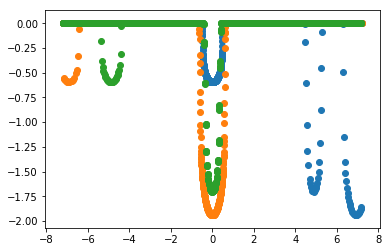

In [21]:
for i, pnum in enumerate([2,0,1]):
    p = np.median(trace["period"][:,pnum])
    t0 = np.median(trace['t0'][:,pnum])

    x_fold = (x[mask] - t0 + 0.5*p) % p - 0.5*p
    
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = trace["light_curve"][:, inds]
    pred = np.percentile(pred, [5, 50, 95], axis=0)
    plt.scatter(x_fold[inds] * 24., pred[1], label="model")
#     plt.xlim(0,1)
    np.savetxt('planet{}-forknicole.csv'.format(i), np.array(
        [x_fold[inds][np.abs(x_fold[inds]) < 4], pred[1][np.abs(x_fold[inds]) < 4]]).T,
              delimiter=',')

In [18]:
x_fold[inds][np.abs(x_fold[inds]) < 4], 

array([-0.29976955, -0.29973747, -0.29966732, ...,  0.29886633,
        0.2989346 ,  0.29899743])

(4721,)

In [70]:
np.percentile(trace['logS0'], [16, 50,84])

array([-3.96137319, -3.53301891, -3.00698105])

In [69]:
0.5401176-0.72496427

-0.18484667